# Drop features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('../data/data_cleaned.csv', sep=',')

# encode target variable: 0: dropout, 1: enrolled, 2: graduated
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation','Target_encoded']

df[col] = df[col].astype('category')


stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs','Marital_status', 'Inflation_rate'], axis = 1)  
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Application_mode                              4424 non-null   category
 1   Application_order                             4424 non-null   int64   
 2   Course                                        4424 non-null   category
 3   Daytime/evening_attendance                    4424 non-null   int64   
 4   Previous_qualification                        4424 non-null   category
 5   Previous_qualification_grade                  4424 non-null   float64 
 6   Mother_qualification                          4424 non-null   category
 7   Father_qualification                          4424 non-null   category
 8   Mother_occupation                             4424 non-null   category
 9   Father_occupation                             4424 n

# Data splitting

X_train shape: (3539, 31)
X_test shape: (885, 31)
y_train shape: (3539,)
y_test shape: (885,)


C:\Users\Martina\AppData\Local\Temp\ipykernel_6588\3702010728.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))


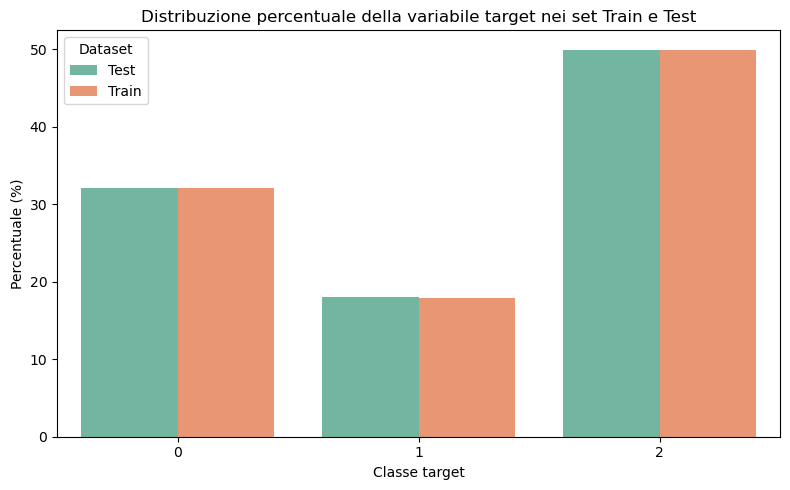

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

X = stud_selected.drop('Target_encoded', axis=1)  
y = stud_selected['Target_encoded']  

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# === Visualizzazione distribuzione target ===
# Ricrea il DataFrame con etichette
dist_df = pd.DataFrame({
    'Set': ['Train'] * len(y_train) + ['Test'] * len(y_test),
    'Target': pd.concat([y_train, y_test])
})

# Calcola le percentuali
percent_df = (
    dist_df.value_counts(['Set', 'Target'])
    .reset_index(name='Count')
    .groupby('Set')
    .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))
    .reset_index(drop=True)
)

# Plot percentuale
plt.figure(figsize=(8, 5))
sns.barplot(data=percent_df, x='Target', y='Percentage', hue='Set', palette='Set2')
plt.title('Distribuzione percentuale della variabile target nei set Train e Test')
plt.xlabel('Classe target')
plt.ylabel('Percentuale (%)')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [4]:
from collections import Counter

print(Counter(y_train))

Counter({2: 1767, 0: 1137, 1: 635})


In [4]:
from FeatTransformer import FeatTransformer 

# Applica solo il FeatureTransformer
ft = FeatTransformer(drop_originals=True)
X_ft = ft.fit_transform(X_train)


In [5]:
mask = X_ft.isna().any()
print("Colonne con NaN prima di SMOTE:")
print(X_ft.columns[mask])

Colonne con NaN prima di SMOTE:
Index([], dtype='object')


SMOTENC

In [7]:
cat_cols = ["Application_mode", "Course", "Gender", "Previous_qualification",  
            "Application_order",  "age_bin", "Mother_occupation",
            "Father_occupation"]    

binary_cols = ["Daytime/evening_attendance","Displaced", "Debtor", "Tuition_fees_up_to_date", "Scholarship_holder"]

cat_cols = cat_cols + binary_cols
cat_indices = [X_ft.columns.get_loc(col) for col in cat_cols]

# Model comparison

In [12]:
#  Model Comparison for Multi-Class Imbalanced Classification
# ============================================
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, classification_report
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

from FeatTransformer import FeatTransformer 
from preprocessing import preprocessor

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models and refined hyperparameter grids
def get_estimators_and_grids():
    estimators = {
        'decision_tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'random_forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'svm': SVC(probability=True, random_state=42),
        'gradient_boosting': GradientBoostingClassifier(random_state=42),
        'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'lightgbm': LGBMClassifier(random_state=42),
        'catboost': CatBoostClassifier(verbose=0, random_state=42, allow_writing_files=False)
    }

    param_grids = {
        'decision_tree': {
            'model__max_depth': [None, 5, 10, 15],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        'random_forest': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20],
            'model__max_features': ['sqrt', 'log2']
        },
        'svm': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        },
        'gradient_boosting': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5]
        },
        'xgboost': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__max_depth': [3, 5],
            'model__subsample': [0.8, 1]
        },
        'lightgbm': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__num_leaves': [31, 50],
            'model__max_depth': [-1, 5]
        },
        'catboost': {
            'model__iterations': [100, 200],
            'model__learning_rate': [0.01, 0.1],
            'model__depth': [6, 10]
        }
    }
    return estimators, param_grids

# Build the imbalanced-learn pipeline
def build_pipeline(model):
    steps = [
        ('feature_transformer', FeatTransformer(drop_originals=True)),
        ('smote', SMOTENC(categorical_features=cat_indices, random_state=42)),
        ('preprocessing', preprocessor),
        ('model', model)
    ]
    return ImbPipeline(steps)

# Tuning, evaluation, and saving function
def tune_and_evaluate(name, estimator, param_grid):
    print(f"Tuning {name}...")
    pipeline = build_pipeline(estimator)
    search = HalvingGridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        factor=2,
        random_state=42,
        verbose=0,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    best = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

    # Evaluate on test set
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)

    metrics = {
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_macro': roc_auc_score(pd.get_dummies(y_test), y_prob, average='macro')
    }
    report = classification_report(y_test, y_pred, output_dict=True)
    per_class_f1 = {cls: report[cls]['f1-score'] for cls in report if cls not in ['accuracy', 'macro avg', 'weighted avg']}
    metrics['per_class_f1'] = per_class_f1

    # Save best model
    joblib.dump(best, f"../models_SMOTENC/best_model_{name}.joblib")
    print(f"Saved best_model_{name}.joblib")

    return metrics, best

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

estimators, grids = get_estimators_and_grids()
results = {}
for name, estimator in estimators.items():
    metrics, _ = tune_and_evaluate(name, estimator, grids[name])
    results[name] = metrics

# Compile and save results
results_df = pd.DataFrame(results).T
print(results_df)
results_df.to_csv('../results/model_comparison_results_SMOTENC.csv')

Tuning decision_tree...
Best params for decision_tree: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Saved best_model_decision_tree.joblib
Tuning random_forest...
Best params for random_forest: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 100}
Saved best_model_random_forest.joblib
Tuning svm...
Best params for svm: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Saved best_model_svm.joblib
Tuning gradient_boosting...
Best params for gradient_boosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Saved best_model_gradient_boosting.joblib
Tuning xgboost...
Best params for xgboost: {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 200, 'model__subsample': 0.8}
Saved best_model_xgboost.joblib
Tuning lightgbm...


  File "c:\Users\Martina\anaconda3\envs\DMML\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 5301, number of used features: 95
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best params for lightgbm: {'model__learning_rate': 0.1, 'model__max_depth': -1, 'model__n_estimators': 100, 'model__num_leaves': 50}
Saved best_model_lightgbm.joblib
Tuning catboost...
Best params for catboost: {'model__depth': 6, 'model__iterations': 100, 'model__learning_rate': 0.1}
Saved best_model_catboost.joblib
                  balanced_accuracy  f1_macro roc_auc_macro  \
decision_tree              0.676719  0.672993      0.845173   
random_forest              0.704974  0.699798      0.882392   
svm                        0.695916  0.691

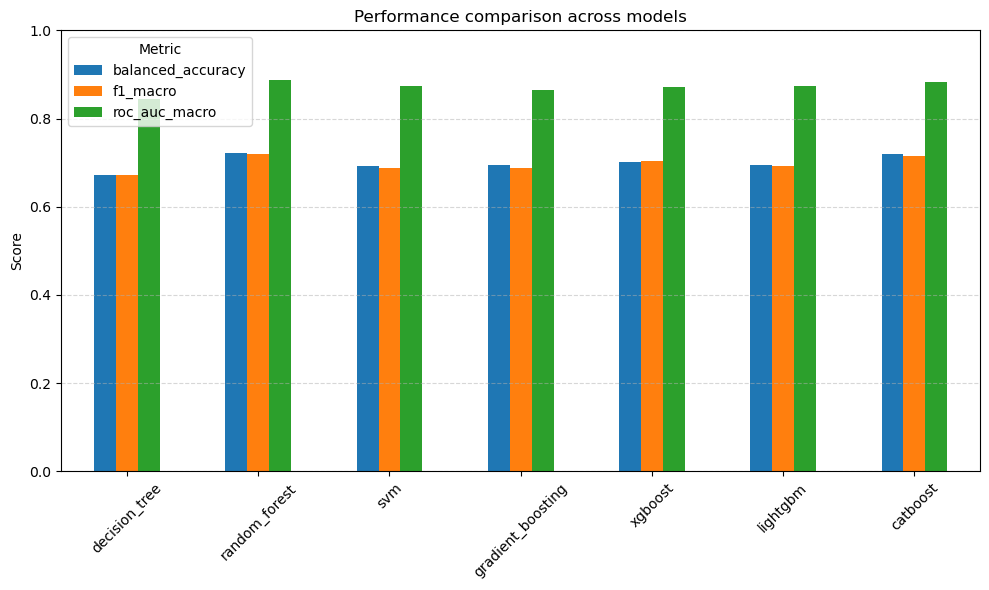

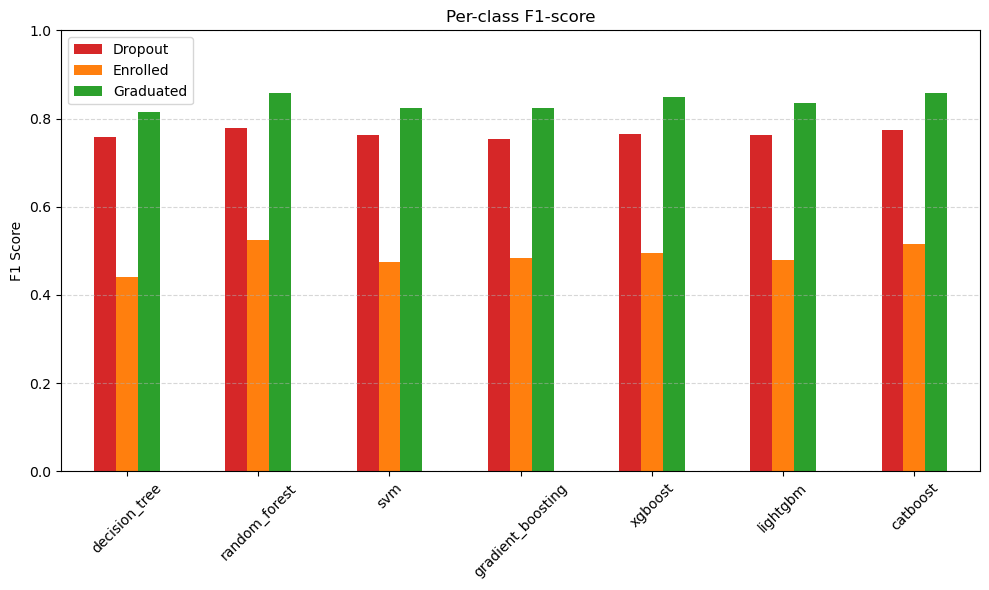

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === 1. Carica il file CSV
df = pd.read_csv("../results/model_comparison_results_2.csv", index_col=0)

# === 2. Converte per_class_f1 da stringa a dizionario
df["per_class_f1"] = df["per_class_f1"].apply(ast.literal_eval)

# === 3. Estrai F1 per ciascuna classe in nuove colonne
df["f1_dropout"]   = df["per_class_f1"].apply(lambda d: d.get('0', None))
df["f1_enrolled"]  = df["per_class_f1"].apply(lambda d: d.get('1', None))
df["f1_graduated"] = df["per_class_f1"].apply(lambda d: d.get('2', None))

# === 4. Plot delle metriche principali
metrics = ["balanced_accuracy", "f1_macro", "roc_auc_macro"]
df[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Performance comparison across models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# === 5. Plot F1 per classe
df[["f1_dropout", "f1_enrolled", "f1_graduated"]].plot(kind="bar", figsize=(10, 6), color=["#d62728", "#ff7f0e", "#2ca02c"])
plt.title("Per-class F1-score")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend(["Dropout", "Enrolled", "Graduated"])
plt.tight_layout()
plt.show()


# Statistical comparison RF-CatBoost

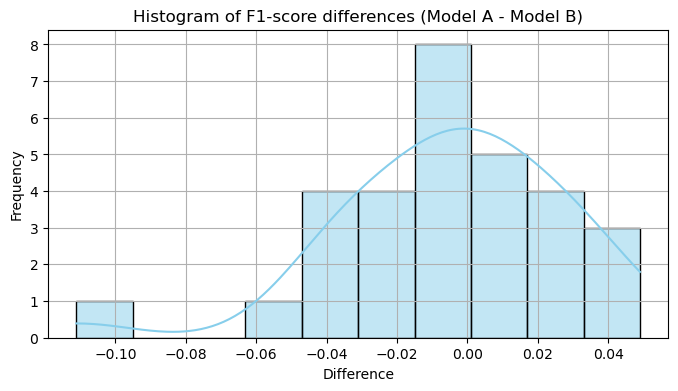

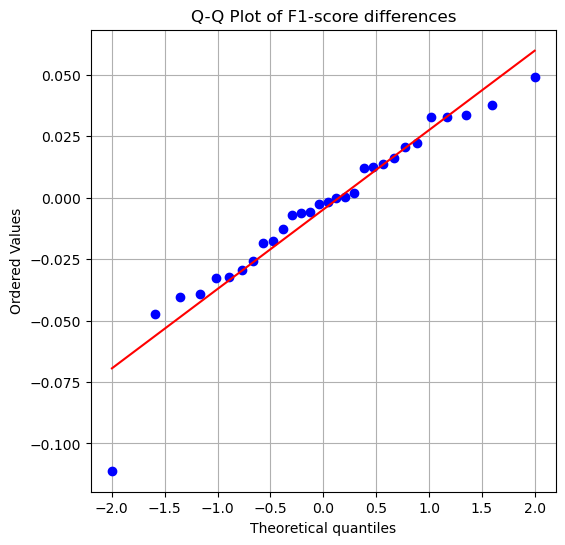

In [4]:
import numpy as np
import joblib
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import shapiro, ttest_rel, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import RepeatedStratifiedKFold


# === Carica i modelli salvati ===
model_a = joblib.load("../models/best_model_catboost.joblib")
model_b = joblib.load("../models/best_model_random_forest.joblib")


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

f1_scores_a = []
f1_scores_b = []

for train_idx, test_idx in cv.split(X_test, y_test):
    X_fold = X_test.iloc[test_idx]
    y_fold = y_test.iloc[test_idx]


    y_pred_a = model_a.predict(X_fold)
    y_pred_b = model_b.predict(X_fold)

    f1_scores_a.append(f1_score(y_fold, y_pred_a, average='macro'))
    f1_scores_b.append(f1_score(y_fold, y_pred_b, average='macro'))

f1_scores_a = np.array(f1_scores_a)
f1_scores_b = np.array(f1_scores_b)

# === Differenze per test statistici ===
diff = f1_scores_a - f1_scores_b


# === Istogramma delle differenze ===
plt.figure(figsize=(8, 4))
sns.histplot(diff, kde=True, bins=10, color='skyblue')
plt.title("Histogram of F1-score differences (Model A - Model B)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === Q-Q plot ===
plt.figure(figsize=(6, 6))
stats.probplot(diff, dist="norm", plot=plt)
plt.title("Q-Q Plot of F1-score differences")
plt.grid(True)
plt.show()




In [5]:
# Perform Shapiro-Wilk test
statistic, p_value = shapiro(diff)

# Print results
print("Shapiro-Wilk Test:")
print(f"Statistic = {statistic:.4f}, p-value = {p_value:.4f}")

Shapiro-Wilk Test:
Statistic = 0.9348, p-value = 0.0660


In [6]:
from scipy.stats import ttest_ind

# Esegui il t-test (equal_var=True assume varianze uguali)
statistic, p_value = ttest_ind(f1_scores_a, f1_scores_b, equal_var=False)

# Risultati
print("T-test for independent samples:")
print(f"Statistic = {statistic:.4f}, p-value = {p_value:.4f}")

T-test for independent samples:
Statistic = -0.4246, p-value = 0.6727


# Performance evaluation

In [7]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import numpy as np


# ==============================
# Confusion Matrix
# ==============================
def confusion_matrix_plot(y_true, y_pred, classes, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# ==============================
# ROC Curve (One-vs-Rest)
# ==============================
def roc_curve_plot(y_true, y_prob, classes, name):

    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Traccia le curve ROC per ogni classe
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - One-vs-Rest ({name})")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()





=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.8436    0.7218    0.7780       284
           1     0.4769    0.5849    0.5254       159
           2     0.8523    0.8620    0.8571       442

    accuracy                         0.7672       885
   macro avg     0.7243    0.7229    0.7202       885
weighted avg     0.7821    0.7672    0.7721       885

Balanced Accuracy: 0.7229


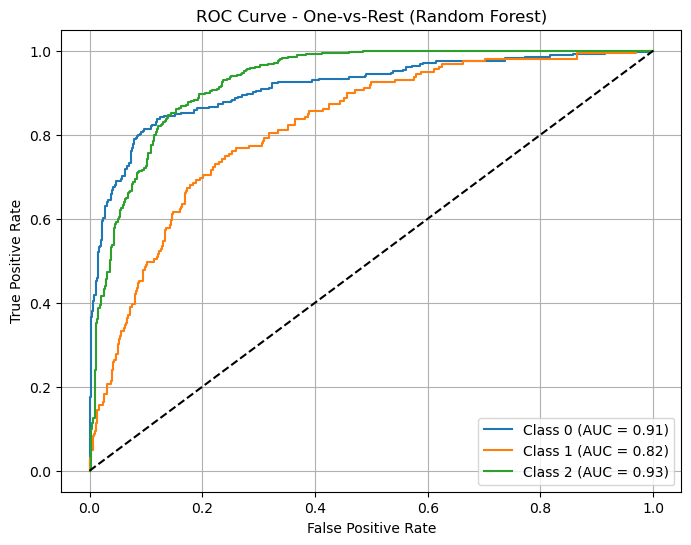

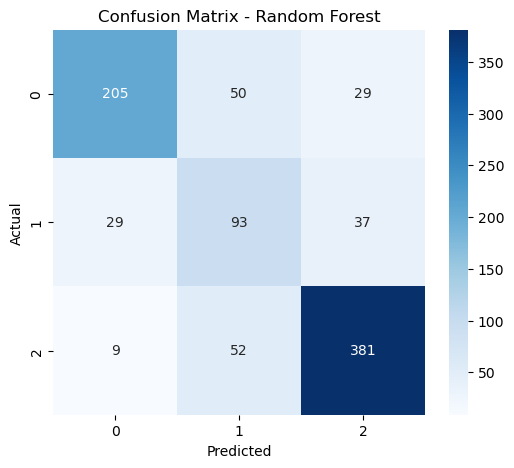

In [8]:
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, roc_auc_score, classification_report
)


model_rf = joblib.load("../models/best_model_random_forest.joblib")  # Cambia il nome se necessario

y_pred = model_rf.predict(X_test)
y_prob = model_rf.predict_proba(X_test)


balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("\n=== Classification Report: Random Forest ===")
print(classification_report(y_test, y_pred, digits=4))

print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model_rf.classes_, "Random Forest")
confusion_matrix_plot(y_test, y_pred, model_rf.classes_, "Random Forest")




=== Classification Report: Catboost ===
              precision    recall  f1-score   support

           0     0.8189    0.7324    0.7732       284
           1     0.4737    0.5660    0.5158       159
           2     0.8594    0.8575    0.8584       442

    accuracy                         0.7650       885
   macro avg     0.7173    0.7186    0.7158       885
weighted avg     0.7771    0.7650    0.7695       885

Balanced Accuracy: 0.7186


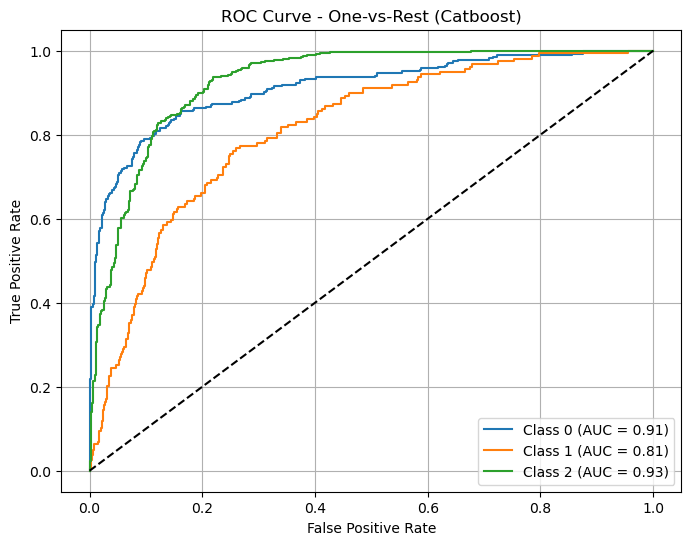

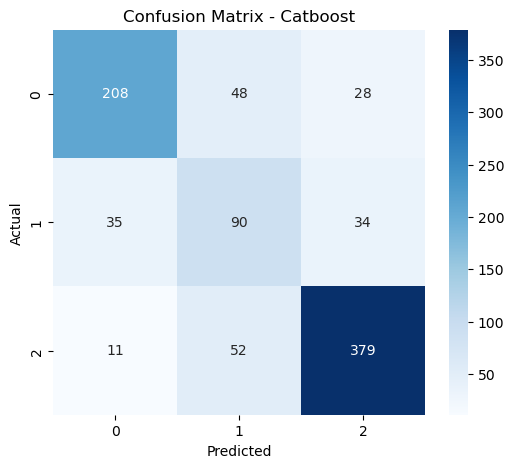

In [9]:
model_cb= joblib.load("../models/best_model_catboost.joblib") 

y_pred = model_cb.predict(X_test)
y_prob = model_cb.predict_proba(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("\n=== Classification Report: Catboost ===")
print(classification_report(y_test, y_pred, digits=4))

print(f"Balanced Accuracy: {balanced_acc:.4f}")

# Plot ROC Curve
roc_curve_plot(y_test, y_prob, model_cb.classes_, "Catboost")
confusion_matrix_plot(y_test, y_pred, model_cb.classes_, "Catboost")